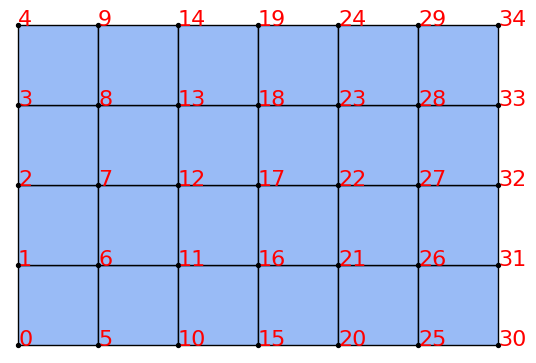

In [17]:
from fealpy.mesh import UniformMesh2d

nelx, nely = 6, 4
domain = [0, 6, 0, 4]
hx = (domain[1] - domain[0]) / nelx
hy = (domain[3] - domain[2]) / nely
mesh = UniformMesh2d(extent=(0, nelx, 0, nely), 
                    h=(hx, hy), origin=(domain[0], domain[2]))

import matplotlib.pyplot as plt
fig = plt.figure()
axes = fig.gca()
mesh.add_plot(axes)
mesh.find_node(axes, showindex=True, 
               color='k', marker='o', markersize=8, fontsize=16, fontcolor='r')
plt.show()

In [18]:
from chaills_operator_integrator import OperatorIntegrator
from fealpy.fem import BilinearForm
from scipy.sparse.linalg import spsolve
from scipy.sparse import spdiags

import numpy as np

def FE(space, mesh, struc, KE, F, fixeddofs):
    """
    有限元计算位移.

    Parameters:
    - space
    - mesh:
    - struc ( ndarray - (nely, nelx) ): 表示结构的 solid(1) 和 void(0) 单元.
    - KE ( ndarray - (ldof*GD, ldof*GD) ): 单元刚度矩阵.
    - F ( ndarray - (gdof*GD, nLoads) ): 节点载荷.
    - fixeddofs (ndarray): 位移约束(supports).

    Returns:
    - uh ( ndarray - (gdof, GD, nLoads) ): 总位移.
    - ue ( ndarray - (NC, ldof*GD, nLoads) ): 单元位移.
    """

    GD = 2
    uh = space.function(dim=GD)
    nLoads = F.shape[-1]
    uh = np.repeat(uh[:, :, np.newaxis], nLoads, axis=2)
    vspace = GD*(space, )
    ldof = vspace[0].number_of_local_dofs()
    vldof = ldof * GD

    integrator = OperatorIntegrator(struc=struc, KE=KE)
    bform = BilinearForm(vspace)
    bform.add_domain_integrator(integrator)
    KK = integrator.assembly_cell_matrix(space=vspace)
    K = bform.assembly()
    print("K0:", K.shape, "\n", K.toarray())

    # 边界条件处理
    dflag = fixeddofs
    uh[dflag] = 0
    F = F - K@uh.reshape(-1, nLoads)
    bdIdx = np.zeros(K.shape[0], dtype=np.int_)
    bdIdx[dflag.flat] = 1
    D0 = spdiags(1-bdIdx, 0, K.shape[0], K.shape[0])
    D1 = spdiags(bdIdx, 0, K.shape[0], K.shape[0])
    K = D0@K@D0 + D1
    F[dflag.flat] = uh.reshape(-1, nLoads)[dflag.flat]
    print("K1:", K.shape, "\n", K.toarray())

    # 线性方程组求解
    uh.flat[:] = spsolve(K, F)

    cell2dof = vspace[0].cell_to_dof()
    NC = mesh.number_of_cells()
    ue = np.zeros((NC, vldof, nLoads))

    for i in range(nLoads):
        reshaped_uh = uh[:, : ,i].reshape(-1)
        # 每个单元的自由度（每个节点两个自由度）
        updated_cell2dof = np.repeat(cell2dof*GD, GD, axis=1) + np.tile(np.array([0, 1]), (NC, ldof))
        ue[:, :, i] = reshaped_uh[updated_cell2dof]

    return uh, ue

In [19]:
def stiff_matrix(nu, E):
    """
    Parameters:
    - nu (flaot): Poisson 比.
    - E (int): 杨氏模量.

    Returns:
    - KE ( ndarray - (NCN*GD, NCN*GD) ): 四节点单元的刚度矩阵.

    Note:
    考虑四节点网格单元中的自由度
    0,1 - 4,5
    2,3 - 6,7
    """
    k_0 = 1/2 - nu/6
    k_1 = 1/8 + nu/8
    k_2 = nu/6
    k_3 = 1/8 - 3*nu/8
    k_4 = -1/4 - nu/12
    k_5 = -1/8 + 3*nu/8
    k_6 = -1/4 + nu/12
    k_7 = -1/8 - nu/8
    k = np.array([k_0, k_1, k_2, k_3, k_4, k_5, k_6, k_7])

    KE = E / (1 - nu**2) * np.array([
        [k[0], k[1], k[2], k[3], k[4], k[5], k[6], k[7]],
        [k[1], k[0], k[7], k[6], k[5], k[4], k[3], k[2]],
        [k[2], k[7], k[0], k[5], k[6], k[3], k[4], k[1]],
        [k[3], k[6], k[5], k[0], k[7], k[2], k[1], k[4]],
        [k[4], k[5], k[6], k[7], k[0], k[1], k[2], k[3]],
        [k[5], k[4], k[3], k[2], k[1], k[0], k[7], k[6]],
        [k[6], k[3], k[4], k[1], k[2], k[7], k[0], k[5]],
        [k[7], k[2], k[1], k[4], k[3], k[6], k[5], k[0]]
    ])

    return KE

E0 = 1.0
nu = 0.3
KE = stiff_matrix(nu=nu, E=E0)

In [20]:
from fealpy.functionspace import LagrangeFESpace as Space
from fealpy.mesh import UniformMesh2d

# nelx, nely = 30, 20
# domain = [0, 30, 0, 20]
nelx, nely = 6, 4
domain = [0, 6, 0, 4]
hx = (domain[1] - domain[0]) / nelx
hy = (domain[3] - domain[2]) / nely
mesh = UniformMesh2d(extent=(0, nelx, 0, nely), 
                    h=(hx, hy), origin=(domain[0], domain[2]))
print("NN:", mesh.number_of_nodes())

p = 1
space = Space(mesh, p=p, doforder='vdims')
GD = 2
vspace = GD*(space, )
gdof = vspace[0].number_of_global_dofs()
vgdof = gdof * GD
print("vgdog:", vgdof)

# 定义荷载 - short cantilever
nLoads = 1
F = np.zeros( (vgdof, nLoads) )
tmp = vgdof - 2*(nely+1) - 1
print("tmp:", tmp)
F[tmp, 0] = -1
print("F:", F)

# 位移约束(supports) - short cantilever
fixeddofs = np.arange(0, 2*(nely+1), 1)
print("fixeddofs:", fixeddofs)

# Load Bearing 单元的索引 - short cantilever
loadBearingIndices = (-1, -1)
print("loadBearingIndices:", loadBearingIndices)

# 定义初始结构为 entirely solid
struc = np.ones((nely, nelx))

NN: 35
vgdog: 70
tmp: 59
F: [[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [-1.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]
fixeddofs: [0 1 2 3 4 5 6 7 8 9]
loadBearingIndices: (-1, -1)


In [21]:
# 优化循环的最大迭代次数
num = 1
for iterNum in range(num):
    # 有限元计算全局位移和局部单元位移
    U, Ue = FE(space=space, mesh=mesh, struc=struc, KE=KE, F=F, fixeddofs=fixeddofs)
    print("U:", U.shape, "\n", U)
    print("Ue:", Ue.shape, "\n", Ue)

K0: (70, 70) 
 [[ 0.49450549  0.17857143  0.05494505 ...  0.          0.
   0.        ]
 [ 0.17857143  0.49450549 -0.17857143 ...  0.          0.
   0.        ]
 [ 0.05494505 -0.17857143  0.98901099 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.98901099 -0.17857143
  -0.24725275]
 [ 0.          0.          0.         ... -0.17857143  0.49450549
  -0.01373626]
 [ 0.          0.          0.         ... -0.24725275 -0.01373626
   0.49450549]]
K1: (70, 70) 
 [[ 1.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          1.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.98901099 -0.17857143
  -0.24725275]
 [ 0.          0.          0.         ... -0.17857143  0.49450549
  -0.01373626]
 [ 0.          0.          0.         ... -0.24725275 -0.01373626
   0.49450549]]
U: (35, 2, 1) 
 [[[ 0.        ]
  